In [1]:
import sys
sys.path.append('/app/SimCLR-OCT/')  # Adjust this to your actual script path
sys.argv = ['main_linear.py', '--batch_size', '32', '--dataset', 'oct', '--ckpt', '/app/SimCLR-OCT/save/SupCon/oct_models/SupCon_oct_resnet50_lr_0.05_decay_0.0001_bsz_8_temp_0.07_trial_0_cosine/ckpt_epoch_50.pth']

# Now, you can import your modules and functions
from main_linear import parse_option, set_model, train, validate
from main_ce import set_loader
from util import adjust_learning_rate, warmup_learning_rate, accuracy, set_optimizer

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # For a nicer heatmap visualization

In [2]:
best_metrics = {
        'accuracy': 0,
        'precision': 0,
        'recall': 0,
        'f1': 0,
        'epoch': 0,  # To track at which epoch the best accuracy was found
        'confusion_matrix': None  # To store the best confusion matrix
    }

In [3]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
def main():
    opt = parse_option()

    # Assuming set_loader is defined elsewhere and correctly imported
    train_loader, val_loader = set_loader(opt)

    model, classifier, criterion = set_model(opt)
    optimizer = set_optimizer(opt, classifier)

    for epoch in range(1, opt.epochs + 1):
        adjust_learning_rate(opt, optimizer, epoch)

        # Training phase
        train_loss, train_acc = train(train_loader, model, classifier, criterion, optimizer, epoch, opt)
        print(f'Train epoch {epoch}, loss: {train_loss:.4f}, accuracy: {train_acc:.2f}%')

        # Validation phase with additional metrics
        val_loss, val_acc, precision, recall, f1, confusion_mat = validate(val_loader, model, classifier, criterion, opt)

        # Print validation results including new metrics
        print(f'Validation epoch {epoch}: Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%, '
              f'Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, ')

        # Update best metrics if current accuracy is higher
        if val_acc > best_metrics['accuracy']:
            best_metrics.update({
                'accuracy': val_acc,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'epoch': epoch,
                'confusion_matrix': confusion_mat  # Store the current confusion matrix
            })

    # Print best metrics after training
    print('Best validation results obtained at epoch {}:'.format(best_metrics['epoch']))
    for metric, value in best_metrics.items():
        if metric != 'epoch' and metric != 'confusion_matrix':  # We don't need to print the epoch again
            print(f'{metric.capitalize()}: {value:.3f}')

In [5]:
if __name__ == "__main__":
    main()

Train: [1][10/33]	BT 0.005 (0.426)	DT 0.000 (0.203)	loss 221.433 (125.052)	Acc@1 53.125 (39.062)
Train: [1][20/33]	BT 0.004 (0.215)	DT 0.000 (0.102)	loss 161.360 (148.043)	Acc@1 51.562 (44.922)
Train: [1][30/33]	BT 0.005 (0.145)	DT 0.000 (0.068)	loss 70.061 (131.127)	Acc@1 32.812 (47.448)
Train epoch 1, loss: 125.8565, accuracy: 47.50%
Test: [0/13]	Time 1.864 (1.864)	Loss 148.8089 (148.8089)	Acc@1 31.250 (31.250)
Test: [10/13]	Time 0.009 (0.180)	Loss 124.1042 (150.4734)	Acc@1 34.375 (25.284)
 * Acc@1 25.000 Precision: 0.062, Recall: 0.250, F1: 0.100
Validation epoch 1: Loss: 150.7019, Accuracy: 25.00%, Precision: 0.062, Recall: 0.250, F1: 0.100, 
Train: [2][10/33]	BT 0.010 (0.223)	DT 0.000 (0.213)	loss 16.611 (45.429)	Acc@1 48.438 (57.188)
Train: [2][20/33]	BT 0.008 (0.164)	DT 0.000 (0.154)	loss 24.012 (38.345)	Acc@1 50.000 (58.516)
Train: [2][30/33]	BT 0.010 (0.112)	DT 0.002 (0.103)	loss 47.402 (39.977)	Acc@1 73.438 (61.458)
Train epoch 2, loss: 39.2269, accuracy: 61.30%
Test: [0/13]	

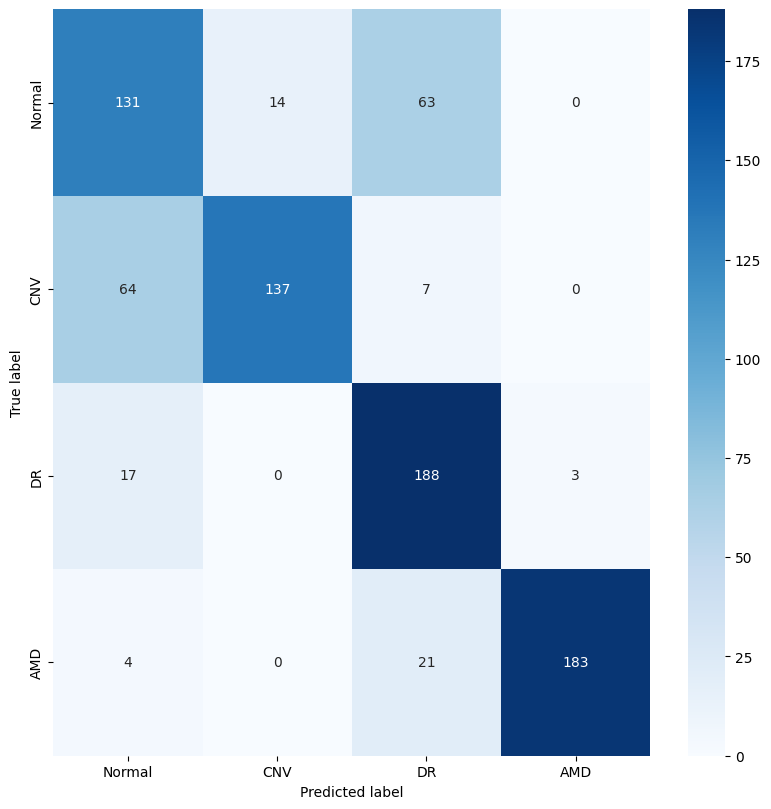

In [6]:
plot_confusion_matrix(best_metrics['confusion_matrix'], ['Normal', 'CNV', 'DR', 'AMD'])  # Use the plotting function defined earlier